MovieWriter ffmpeg unavailable; using Pillow instead.


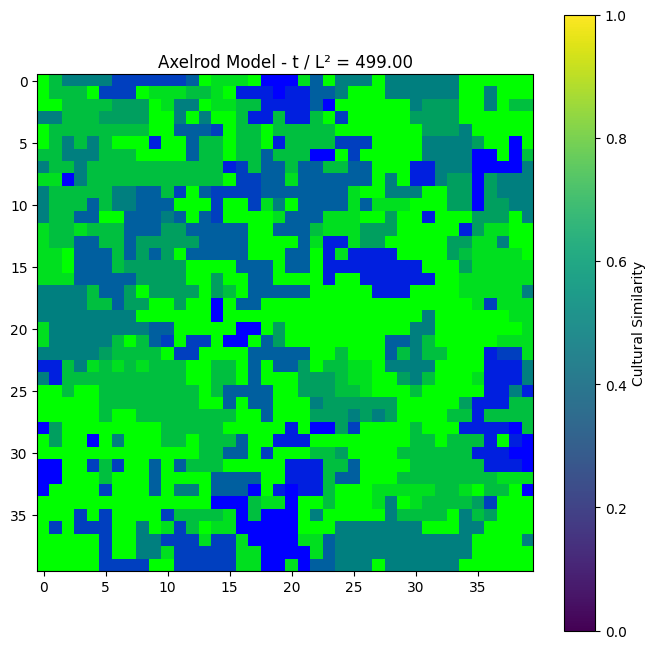

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from tqdm import tqdm

# Parameters
L = 40  # Grid size (LxL)
F = 2   # Number of cultural features
Q = 5  # Number of traits per feature
steps = (L**2)*300  # Total steps
frames = 500  # Number of frames in the animation
interval = 50  # Milliseconds between frames
time = 0

# Initialize the grid with random traits
grid = np.random.randint(0, Q, (L, L, F))


def overlap(a, b):
    """Calculate the number of shared features between two agents."""
    return sum(a[i] == b[i] for i in range(F))


def interact(x, y, nx, ny):
    """Interaction rule between neighboring agents."""
    global grid

    # Calculate cultural similarity
    shared_features = overlap(grid[x, y], grid[nx, ny])
    if shared_features == 0:
        return  # No interaction

    # Probability of interaction
    prob = shared_features / F
    if np.random.rand() < prob:
        # Choose a feature to change
        diff_features = [i for i in range(F) if grid[x, y, i] != grid[nx, ny, i]]
        if diff_features:
            feature = random.choice(diff_features)
            grid[x, y, feature] = grid[nx, ny, feature]


def simulate(steps_per_frame):
    """Perform multiple steps of simulation."""
    for _ in range(steps_per_frame):
        # Pick a random agent
        x, y = np.random.randint(0, L, size=2)

        # Pick a random neighbor
        neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        dx, dy = random.choice(neighbors)
        nx, ny = (x + dx) % L, (y + dy) % L  # Periodic boundaries

        # Interact with the neighbor
        interact(x, y, nx, ny)
        global time 
        time+=1


def get_culture_map():
    """Generate a cultural map with shades of blue based on cultural features."""
    # Normalize the grid to [0, 1] for blending
    norm_grid = grid / (Q - 1)  # Normalize trait values to [0, 1]

    # Blend features into a single value (weighted mean)
    weights = np.linspace(0.5, 1.0, F)  # Slight weighting for smooth transitions
    blended = np.tensordot(norm_grid, weights[:F], axes=(2, 0))  # Linear blending

    # Normalize and clip blended values to [0, 1]
    blended = np.clip(blended, 0, 1)  # Ensure valid range

    # Map blended values to shades of blue
    culture_map = np.stack([np.zeros_like(blended), blended, 1 - blended], axis=2)  # RGB for blue shades

    # Ensure the final RGB values are clipped to [0, 1]
    culture_map = np.clip(culture_map, 0, 1)

    return culture_map

# Animation setup
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(get_culture_map(), cmap="viridis", vmin=0, vmax=1)
plt.colorbar(im, ax=ax, label="Cultural Similarity")
ax.set_title("Axelrod Model - Cultural Dissemination")


def update(frame):
    """Update function for animation."""
    simulate(steps // frames)  # Run simulation for some steps
    im.set_array(get_culture_map())  # Update the image
    ax.set_title(f"Axelrod Model - t / L² = {frame:.2f}")  # Title with normalized time


# Create and save the animation
ani = animation.FuncAnimation(fig, update, frames=frames, interval=interval)

# Save the animation as a video
ani.save('axelrod_simulation.gif', writer='ffmpeg')

plt.show()